In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

In [2]:
# Define utility functions

def encode_day_sin(date):
  return np.sin(date.weekday * (2 * np.pi / 7))

def encode_day_cos(date):
  return np.cos(date.weekday * (2 * np.pi / 7))

def encode_week_sin(date):
  return np.sin(date.week * (2 * np.pi / 52))

def encode_week_cos(date):
  return np.cos(date.week * (2 * np.pi / 52))

def process_7d_data(data, key):
  unprocessed_values = data[key]
  running_7d_avg = []
  delta_7d_avg = []
  for i, data_point in enumerate(unprocessed_values):
    prev_index = i-8
    start_range = prev_index if prev_index >= 0 else 0
    prev_7_days = unprocessed_values[start_range : i]
    if prev_7_days.empty : prev_7_days = [data_point]
    running_7d_avg.append(np.mean(prev_7_days))
    if i == 0:
      delta_7d_avg.append(0)
    else:
      delta_7d_avg.append(running_7d_avg[i] - running_7d_avg[i-1])
  data['running_7d_avg_' + key] = running_7d_avg
  data['delta_7d_avg_' + key] = delta_7d_avg
  return data

In [5]:
# Import raw data and preview contents
raw_arrival_data = pd.read_csv("./training_data/RUHS_2022_2023_visit_ESI_details_processed.csv", parse_dates=['date'], infer_datetime_format=True)
raw_weather_data = pd.read_csv("./training_data/RUHS_2022_2023_weather_processed.csv", parse_dates=['DATE'], infer_datetime_format=True)

# TODO: find traffic data (prev week?)
# TODO: find consumer spending data

# Join arrival data with weather data
raw_data = pd.merge(raw_arrival_data, raw_weather_data, left_on=['date'], right_on=['DATE'], how='inner')

# Preview our data
print(raw_data.head(5))
print(raw_data.loc[raw_data['arrive_num'].idxmax()])

        date  arrive_num  acuity_avg  acuity_1_num  acuity_2_num  \
0 2022-01-01         240    3.148305             1            48   
1 2022-01-02         303    3.260870             5            42   
2 2022-01-03         281    3.150000             2            51   
3 2022-01-04         301    3.300000             7            33   
4 2022-01-05         306    3.201320             9            50   

   acuity_3_num  acuity_4_num  acuity_5_num       DATE  AWND  PRCP  TAVG  \
0           108            73             6 2022-01-01  4.47   0.0  49.0   
1           137           100            15 2022-01-02  8.05   0.0  49.0   
2           140            77            10 2022-01-03  1.34   0.0  49.0   
3           130           123             7 2022-01-04  1.34   0.0  49.0   
4           132            95            17 2022-01-05  2.01   0.0  56.0   

   TMAX  TMIN  
0  61.0  39.0  
1  62.0  40.0  
2  65.0  37.0  
3  63.0  37.0  
4  76.0  41.0  
date            2022-11-28 00:00:00
ar

/var/folders/tn/_kcr3c216vd2khp59103ysnh0000gn/T/ipykernel_32596/494599680.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  raw_data['week_of_year'] = raw_data.date.dt.week # 0-52
/var/folders/tn/_kcr3c216vd2khp59103ysnh0000gn/T/ipykernel_32596/3383511204.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  return np.sin(date.week * (2 * np.pi / 52))
/var/folders/tn/_kcr3c216vd2khp59103ysnh0000gn/T/ipykernel_32596/3383511204.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  return np.cos(date.week * (2 * np.pi / 52))


        date  arrive_num  acuity_avg  acuity_1_num  acuity_2_num  \
0 2022-01-01         240    3.148305             1            48   
1 2022-01-02         303    3.260870             5            42   
2 2022-01-03         281    3.150000             2            51   
3 2022-01-04         301    3.300000             7            33   
4 2022-01-05         306    3.201320             9            50   

   acuity_3_num  acuity_4_num  acuity_5_num       DATE  AWND  ...  \
0           108            73             6 2022-01-01  4.47  ...   
1           137           100            15 2022-01-02  8.05  ...   
2           140            77            10 2022-01-03  1.34  ...   
3           130           123             7 2022-01-04  1.34  ...   
4           132            95            17 2022-01-05  2.01  ...   

   running_7d_avg_acuity_4_num  delta_7d_avg_acuity_4_num  \
0                    73.000000                   0.000000   
1                    73.000000                   0.000

/var/folders/tn/_kcr3c216vd2khp59103ysnh0000gn/T/ipykernel_32596/494599680.py:58: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(raw_data.corr())


<Axes: >

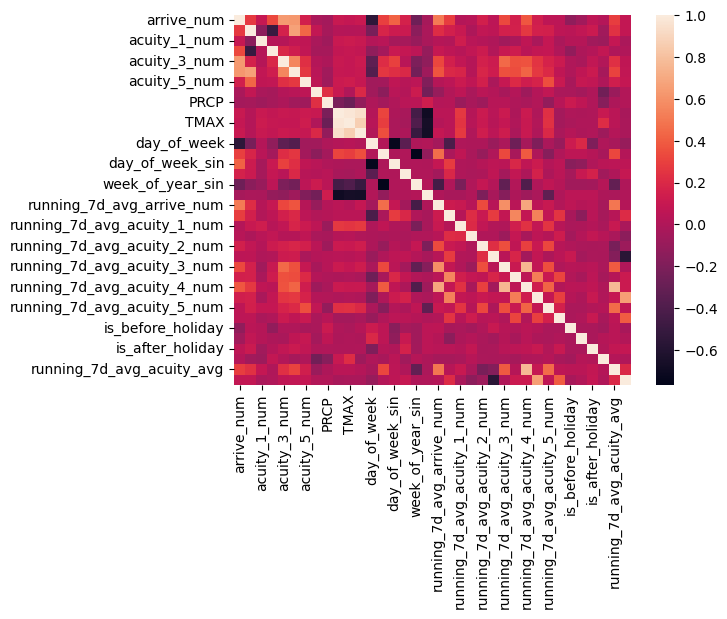

In [86]:
# Data pre-processing

# Cyclic encoding for day of week
raw_data['date'] = pd.to_datetime(raw_data.date)
raw_data['day_of_week'] = raw_data.date.dt.weekday # Monday=0, Sunday=6
raw_data['week_of_year'] = raw_data.date.dt.week # 0-52

raw_data['day_of_week_sin'] = encode_day_sin(raw_data['date'].dt)
raw_data['day_of_week_cos'] = encode_day_cos(raw_data['date'].dt)

# Cyclic encoding for week of year
raw_data['week_of_year_sin'] = encode_week_sin(raw_data['date'].dt)
raw_data['week_of_year_cos'] = encode_week_cos(raw_data['date'].dt)

# Calculate running 7-day average and delta avg
raw_data = process_7d_data(raw_data, 'arrive_num')
raw_data = process_7d_data(raw_data, 'acuity_avg')
raw_data = process_7d_data(raw_data, 'acuity_1_num')
raw_data = process_7d_data(raw_data, 'acuity_2_num')
raw_data = process_7d_data(raw_data, 'acuity_3_num')
raw_data = process_7d_data(raw_data, 'acuity_4_num')
raw_data = process_7d_data(raw_data, 'acuity_5_num')
    
# Add holiday data
holidays = np.array(USFederalHolidayCalendar().holidays(start='2022-01-02', end=pd.to_datetime("today")))

avail_dates = raw_data['date']
is_before_holiday = []
is_holiday = []
is_after_holiday = []
for date in avail_dates:
    delta_from_holidays = np.datetime64(date) - holidays
    days_from_holiday = [(x / np.timedelta64(1, 'D')) + 1 for x in delta_from_holidays]
    smallest_delta = min(days_from_holiday, key=abs)
    is_before_holiday.append(np.isclose(smallest_delta, -1.0))
    is_holiday.append(np.isclose(smallest_delta, 0.0))
    is_after_holiday.append(np.isclose(smallest_delta, 1.0))
raw_data['is_before_holiday'] = is_before_holiday
raw_data['is_holiday'] = is_holiday
raw_data['is_after_holiday'] = is_after_holiday

temps = raw_data['TMAX']
delta_max_temps = []
# TODO: Add delta max temp before normalizing
for i, temp in enumerate(temps):
  if i == 0:
    delta_max_temps.append(0)
  else:
    delta_max_temps.append(temp - temps[i-1])
raw_data['delta_max_temp'] = delta_max_temps

# Normalize temps
raw_data['TMAX'] = raw_data['TMAX'] / 100
raw_data['TMIN'] = raw_data['TMIN'] / 100

# Preview our processed data
print(raw_data.head(5))
sns.heatmap(raw_data.corr())

In [143]:
# Define features and labels

# Labels: values we want to predict
labels = raw_data['arrive_num']
#labels = raw_data['acuity_avg']
#labels = raw_data['acuity_3_num']

# Features: data that will train model, corresponds to input data when predicting labels
# We exclude date column, as this was only used for pre-processing
features = raw_data[['day_of_week',
                     'day_of_week_sin',
                     'day_of_week_cos',
                     'week_of_year',
                     'week_of_year_sin',
                     'week_of_year_cos',
                     'PRCP',
                     'TMAX',
                     'delta_max_temp',
                     'running_7d_avg_arrive_num',
                     'delta_7d_avg_arrive_num',
                     'running_7d_avg_acuity_avg',
                     'delta_7d_avg_acuity_avg',
                     'running_7d_avg_acuity_1_num',
                     'delta_7d_avg_acuity_1_num',
                     'running_7d_avg_acuity_2_num',
                     'delta_7d_avg_acuity_2_num',
                     'running_7d_avg_acuity_3_num',
                     'delta_7d_avg_acuity_3_num',
                     'running_7d_avg_acuity_4_num',
                     'delta_7d_avg_acuity_4_num',
                     'running_7d_avg_acuity_5_num',
                     'delta_7d_avg_acuity_5_num',
                     'is_holiday',
                     'is_after_holiday']]
feature_list = list(features.columns)

# NOTE: GOOD LABELS

# NOTE: BAD LABELS: day of week, week of year cos

features = np.asarray(features).astype(np.float32)

# Split into training and test data
train_features, validation_features, train_labels, validation_labels = train_test_split(features, labels, test_size = 0.10)

print(train_features.shape[1])

25


2/2 [==============================] - 0s 1ms/step - loss: 504.3983 - mae: 18.5611


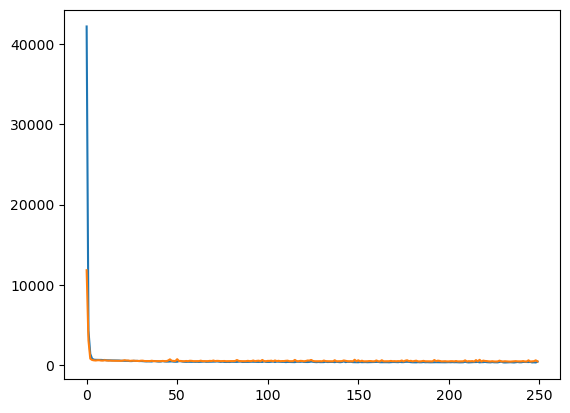

In [145]:
# Create and train a Multilayer Perceptron Neural Network

# Step 1: define model
model = Sequential()
model.add(Dense(128, activation="relu", input_shape = (train_features.shape[1],)))
model.add(Dense(64, activation="relu", kernel_regularizer = 'l2'))
model.add(Dense(32, activation="relu", kernel_regularizer = 'l2'))
model.add(Dense(16, activation="relu", kernel_regularizer = 'l2'))
model.add(Dense(8, activation="relu", kernel_regularizer = 'l2'))
model.add(Dense(4, activation="relu", kernel_regularizer = 'l2'))
model.add(Dense(2, activation="relu", kernel_regularizer = 'l2'))
# Output is a single neuron with a linear activation function
model.add(Dense(1, activation="linear"))

# Step 2: Compile model
model.compile(optimizer = 'adam', loss = 'mse', metrics = 'mae')
#Step3. Fit the model
history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=250,batch_size=30, verbose=0)
#Step4.1 Evaluate the model
loss, mae = model.evaluate(validation_features, validation_labels)
#Step4.2 Plot the learning curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.show()


15/15 [==============================] - 0s 696us/step
Training Set R-Square= 0.5713346522785399


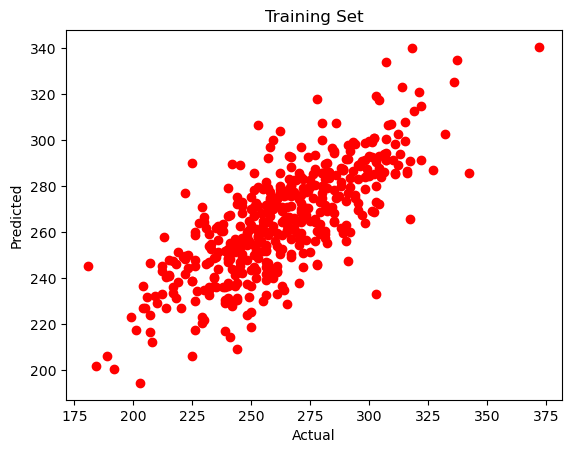

In [146]:
# See how good our model was at predicting its own training data (not that impressive)
train_set_predictions = model.predict(train_features)
plt.plot(train_labels, train_set_predictions,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = r2_score(train_labels, train_set_predictions)
print("Training Set R-Square=", TestR2Value)

2/2 [==============================] - 0s 2ms/step
Validation Set R-Square= 0.5593518233163601
Mean Absolute Error= 18.56114107019761


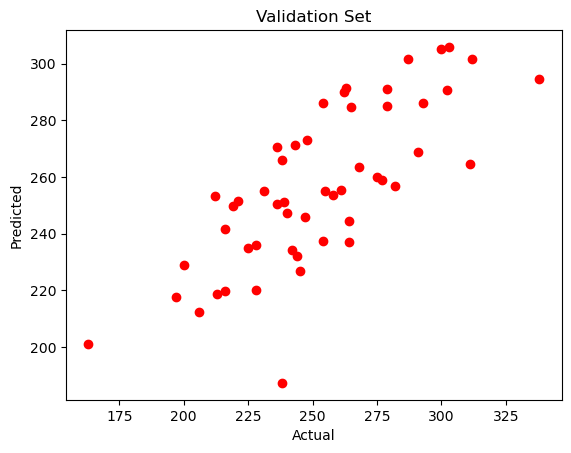

In [147]:
# Important part... how good was our model at predicting validation data
validation_set_predictions = model.predict(validation_features)
plt.plot(validation_labels, validation_set_predictions,'ro')
plt.title('Validation Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for validation set
r2_val = r2_score(validation_labels, validation_set_predictions)
mae_val = mean_absolute_error(validation_labels, validation_set_predictions)
print("Validation Set R-Square=",r2_val)
print("Mean Absolute Error=", mae_val)

In [12]:
# Predict arbitrary date

def predict_vol_by_date(date_str, avg_7d, precip, max_temp):
  date = pd.to_datetime(date_str)
  query = np.array([encode_day_sin(date), encode_day_cos(date), encode_week_sin(date), encode_week_cos(date), precip, max_temp / 100, avg_7d])

  # Holiday stuff
  holidays = np.array(USFederalHolidayCalendar().holidays(start=pd.to_datetime('2023-01-01'), end=pd.to_datetime("today")))
  delta_from_holidays = np.datetime64(date) - holidays
  days_from_holiday = [(x / np.timedelta64(1, 'D')) + 1 for x in delta_from_holidays]
  smallest_delta = min(days_from_holiday, key=abs)
  is_before_holiday.append(np.isclose(smallest_delta, -1.0))
  is_holiday.append(np.isclose(smallest_delta, 0.0))
  is_after_holiday.append(np.isclose(smallest_delta, 1.0))

  # Log our parameters
  print(query)

  # Log prediction
  print(model.predict(query))

# Make a prediction
#predict_vol_by_date('2023-03-14', 280, 0, 59) this is broken